In [78]:
import os
os.environ["DISPLAY"] = ":1"
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import box as Box
from shapely import affinity
from typing import List

import vista
from vista.entities.sensors.camera_utils.ViewSynthesis import DepthModes
from vista.utils import logging, misc
from vista.tasks import MultiAgentBase
from vista.utils import transform

In [79]:
def compute_overlap(poly: Box, polys: List[Box]) -> List[float]:
    """ Compute overlapping area between 1 polygons and N polygons.

    Args:
        poly (shapely.geometry.Box): A polygon.
        poly (List): A list of polygon.

    Returns:
        List[float]: Intersecting area between polygons.

    """
    n_polys = len(polys)
    overlap = np.zeros((n_polys))
    for i in range(n_polys):
        intersection = polys[i].intersection(poly)
        overlap[i] = intersection.area
    return overlap

In [80]:
def my_reward_fn(task, agent_id, **kwargs):
    agent = [_a for _a in task.world.agents if _a.id == agent_id][0]
    other_agents = [_a for _a in task.world.agents if _a.id != agent_id]

    # Lane reward
    q_lat = np.abs(agent.relative_state.x)
    road_width = agent.trace.road_width
    z_lat = road_width / 2
    lane_reward = round(1 - (q_lat/z_lat)**2, 4)

    # collision avoidance reward
    agent2poly = lambda _x: misc.agent2poly(
        _x, ref_dynamics=agent.human_dynamics)
    poly = agent2poly(agent).buffer(5)
    other_polys = list(map(agent2poly, other_agents))
    overlap = (compute_overlap(poly, other_polys) / poly.area) * 10

    reward = lane_reward - overlap
    return reward, {}

2023-10-02 22:08:27,688::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-10-02 22:08:27,891::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-10-02 22:08:28,100::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-10-02 22:08:28,315::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv


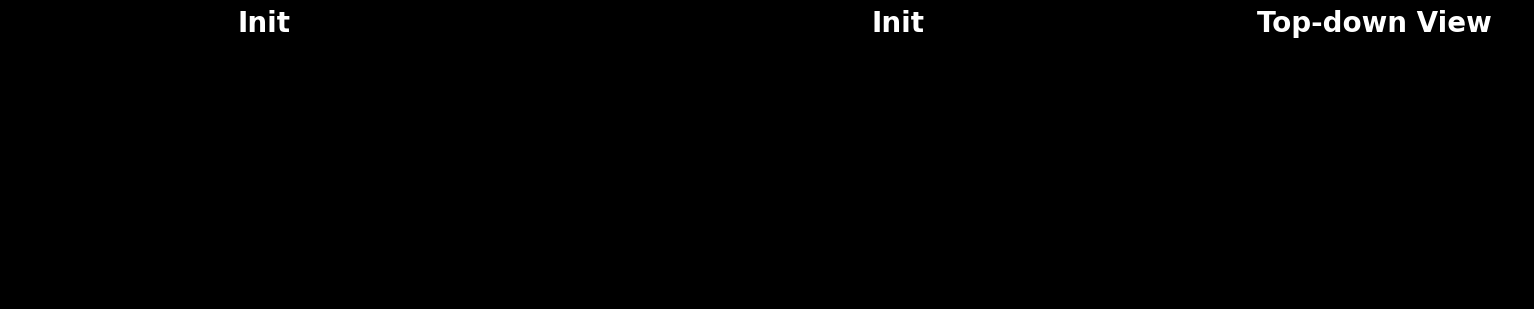

In [100]:
# Initialize the simulator
trace_config = dict(
    road_width=4,
    reset_mode='default',
    master_sensor='camera_front',
)
car_config = dict(
    length=5.,
    width=2.,
    wheel_base=2.78,
    steering_ratio=14.7,
    lookahead_road=True,
)
sensors_config = [
    dict(
        type='camera',
        # camera params
        name='camera_front',
        size=(200, 320),
        # rendering params
        depth_mode=DepthModes.FIXED_PLANE,
        use_lighting=False,
    )
]
task_config = dict(n_agents=2,
                    mesh_dir="../vista/carpack01",
                    init_dist_range=[6., 10.],
                    init_lat_noise_range=[-5., 5.],
                    reward_fn=my_reward_fn)
display_config = dict(road_buffer_size=1000, )

ego_car_config = copy.deepcopy(car_config)
ego_car_config['lookahead_road'] = True
trace_root = "../vista/vista_traces"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]
env = MultiAgentBase(trace_paths=trace_path,
                        trace_config=trace_config,
                        car_configs=[car_config] * task_config['n_agents'],
                        sensors_configs=[sensors_config] + [copy.deepcopy(sensors_config)] *
                        (task_config['n_agents'] - 1),
                        task_config=task_config)
display = vista.Display(env.world, display_config=display_config)

In [101]:
def generate_human_actions(world):
    actions = dict()
    for agent in world.agents:
        if agent.id != env.ego_agent.id:
            actions[agent.id] = np.array([0.0,0.0])
        else:
            # Sample a random curvature (between +/- 1/3), keep speed constant
            # curvature = np.random.uniform(-1/5, 1/5)
            if np.random.binomial(1, 0.0):
                curvature = np.random.normal(agent.trace.f_curvature(agent.timestamp), .1)
            else:
                curvature = agent.trace.f_curvature(agent.timestamp)
            actions[agent.id] = np.array([curvature, agent.trace.f_speed(agent.timestamp)])
    return actions

2023-10-02 22:08:44,377::WARNING::[vista.entities.sensors.Camera.reset] No flow data
2023-10-02 22:08:44,565::WARNING::[vista.entities.sensors.Camera.reset] No flow data


Ego agent id: 78609f


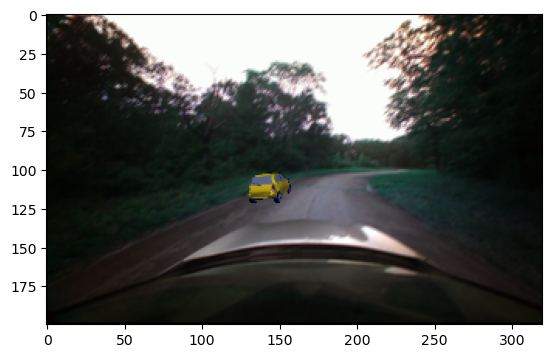

In [102]:
# start env
# env.world.set_seed(47)
observations = env.reset();
display.reset()  # reset should be called after env reset
print(f"Ego agent id: {env.ego_agent.id}")
plt.imshow(observations[env.ego_agent.id]['camera_front'])

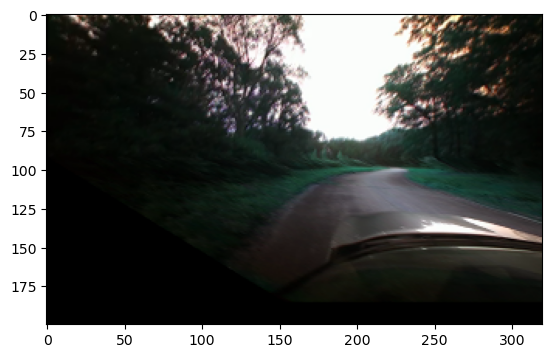

In [108]:
plt.imshow(observations['2abb7d']['camera_front'])

In [186]:
# import numpy as np
# # Example data
# data = [1, 4, 7, 9, 6, 3, 1, 5, 8, 10]
# first_derivative = np.gradient(data)
# second_derivative = np.gradient(first_derivative)
# plt.plot(data,'-')
# plt.plot(first_derivative,'--')
# plt.plot(second_derivative,':')

In [187]:
def calculate_jitter_reward(steering_history):
    first_derivative = np.gradient(steering_history)
    second_derivative = np.gradient(first_derivative)
    jitter_reward = -np.abs(second_derivative[-1])
    return jitter_reward

In [188]:
def calculate_progress(env, initial_frame):
    total_frames = len(env.ego_agent.trace.good_frames['camera_front'][0])
    track_left = total_frames - initial_frame
    progress = env.ego_agent.frame_index - initial_frame
    progress_percentage = np.round(progress/track_left, 4)
    return progress_percentage

In [189]:
steering_history = [0.0, env.ego_agent.ego_dynamics.steering]
done = False
initial_frame = env.ego_agent.frame_index
steps = 0
while not done:
    # follow nominal trajectories for all agents
    actions = generate_human_actions(env.world)

    # step environment
    observations, rewards, dones, infos = env.step(actions)
    steering = env.ego_agent.ego_dynamics.steering
    steering_history.append(steering)
    jitter_reward = calculate_jitter_reward(steering_history)
    print(jitter_reward)

    # print(f"Steering: {steering}")
    # print(f"Second steering derivative: {jitter_reward}")
    
    # print(f"Reward: {rewards[env.ego_agent.id]}")
    done = dones[env.ego_agent.id]
    reward = 0 if done else rewards[env.ego_agent.id] + jitter_reward
    steps += 1

    img = display.render()
    cv2.imshow("test", img[:, :, ::-1])
    key = cv2.waitKey(20)
    plt.pause(.05)
    if key == ord('q'):
        break
print(calculate_progress(env, initial_frame)*100)
print(steps)

-0.012863429344838107
-0.00030383652846475463
-8.483848999655402e-06
-7.848374567399549e-05
-2.3863896415459926e-05
-4.4129080666610934e-05
-3.628418399280464e-05
-1.3770055513643784e-05
-8.581793474876642e-07
-1.1519978738230852e-06
-3.401741921956608e-05
-2.785964487777605e-05
-0.00012075808877916316
-7.148511000941438e-05
-5.396434832600008e-06
-2.247386598058093e-05
-3.7403586851253445e-05
-4.630851452071087e-05
-9.00401302159461e-05
-4.216431014213151e-05
-2.9858584722299887e-05
-8.864454372081287e-05
-0.00010299665425782777
-3.3449838603541275e-05
-4.744347157163275e-05
-0.00010792987106215783
-2.4647051177190994e-05
-6.599459447991212e-05
-2.8713643411465255e-05
-8.070263545897731e-05
-7.463489980242665e-05
-8.879275258375733e-05
-5.09249919253274e-05
-2.5703359358802014e-05
-1.4394029426499037e-05
-1.4839047999266886e-05
-2.2208625241777746e-07
-7.625008389877479e-06
-4.9657014425493395e-06
-3.766329275950984e-05
-7.628808509097418e-05
-0.00013963894955691322
-3.877552569050047

In [191]:
rewards[env.ego_agent.id]

array([1.])

In [228]:
# follow nominal trajectories for all agents
actions = generate_human_actions(env.world)

# step environment
observations, rewards, dones, infos = env.step(actions)

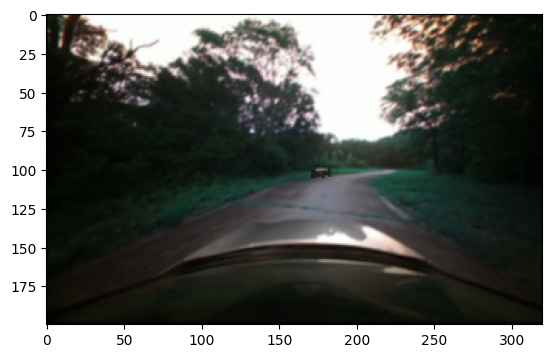

In [233]:
plt.imshow(observations[env.ego_agent.id]['camera_front'])

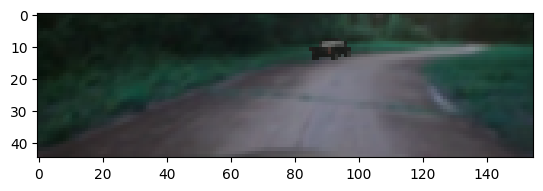

In [274]:
full_obs = observations[env.ego_agent.id]['camera_front']
## Data preprocessing functions ##
def preprocess(env, full_obs):
    # Extract ROI
    i1, j1, i2, j2 = env.ego_agent.sensors[0].camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    return obs
cropped_img = preprocess(env, full_obs)
plt.imshow(cropped_img)

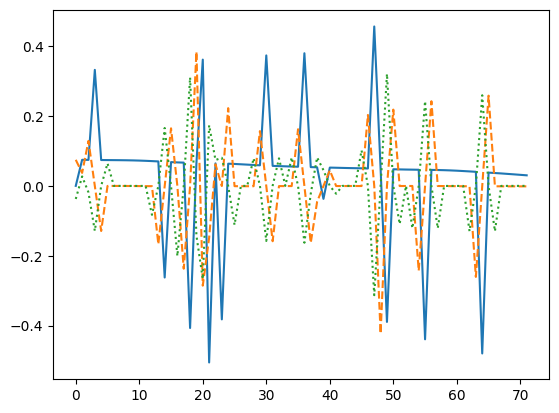

In [127]:
import pandas as pd
series = pd.Series(steering_history)
smoothed_data = series.rolling(window=1, min_periods=1).mean()
first_derivative = np.gradient(steering_history)
second_derivative = np.gradient(first_derivative)
plt.plot(smoothed_data,'-')
plt.plot(first_derivative,'--')
plt.plot(second_derivative,':')

In [2]:
# Define dynamics
def _ode_func(t, z):
    _x, _y, _phi, _delta, _v = z
    u_delta = steering_velocity
    u_a = acceleration
    new_z = np.array([
        -_v * np.sin(_phi),  # swap x-y axis with sign change
        _v * np.cos(_phi),
        _v / self._wheel_base * np.tan(_delta),
        u_delta,
        u_a
    ])
    return new_z

In [ ]:
# Solve ODE
z_0 = np.array(
    [self._x, self._y, self._yaw, self._steering, self._speed])
solver = ode_solve.RK45(_ode_func, 0., z_0, dt)
steps = 0

In [53]:
import torch
torch.sigmoid(torch.tensor(0.1))

tensor(0.5250)

In [64]:
import torch
import torch.nn as nn 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

In [66]:
model = CNN()
x = torch.rand((100))
# model(x)
model.forward(x)

tensor([0.1725], grad_fn=<AddBackward0>)